In [1]:
import numpy as np
import torch

from functools import partial

from kusanagi.shell import cartpole
from kusanagi.base import ExperienceDataset, apply_controller
from kusanagi.ghost.control import RandPolicy

from prob_mbrl import utils, models, algorithms, losses, train_regressor
torch.set_num_threads(2)

In [2]:
def forward(states, actions, dynamics, **kwargs):
    deltas, rewards = dynamics(
        (states, actions), return_samples=True,
        separate_outputs=True, **kwargs)
    next_states = states + deltas
    return next_states, rewards


def reward_fn(states, target, Q, angle_dims):
    states = utils.to_complex(states, angle_dims)
    reward = losses.quadratic_saturating_loss(states, target, Q)
    return reward

In [3]:
# parameters
H = 25
N_particles = 100
dyn_components = 4
dyn_hidden = [200]*2
pol_hidden = [200]*2
use_cuda = False

# initialize environment
env = cartpole.Cartpole()

# initialize reward/cost function
target = torch.tensor([0, 0, 0, np.pi]).float()
D = target.shape[-1]
U = 1
learn_reward = False
maxU = np.array([10.0])
angle_dims = torch.tensor([3]).long()
target = utils.to_complex(target, angle_dims)
Da = target.shape[-1]
Q = torch.zeros(Da, Da).float()
Q[0, 0] = 1
Q[0, -2] = env.l
Q[-2, 0] = env.l
Q[-2, -2] = env.l**2
Q[-1, -1] = env.l**2
Q /= 0.1
if learn_reward:
    reward_func = None
else:
    reward_func = partial(
        reward_fn, target=target, Q=Q, angle_dims=angle_dims)

# initialize dynamics model
dynE = 2*(D+1) if learn_reward else 2*D
dyn_model = models.dropout_mlp(
            Da+U, (dynE+1)*dyn_components, dyn_hidden,
            dropout_layers=[models.modules.CDropout(0.5, 0.1)
                            for i in range(len(dyn_hidden))],
            nonlin=torch.nn.ReLU,
            weights_initializer=torch.nn.init.xavier_normal_,
            biases_initializer=partial(torch.nn.init.uniform_, a=-1.0, b=1.0),
        )
dyn = models.DynamicsModel(
    dyn_model, reward_func=reward_func,
    angle_dims=angle_dims,
    output_density=models.MixtureDensity(dynE/2, dyn_components)).float()

# initalize policy
pol_model = models.dropout_mlp(
        Da, U, pol_hidden,
        dropout_layers=[models.modules.BDropout(0.5)
                        for i in range(len(pol_hidden))],
        nonlin=torch.nn.ReLU,
        output_nonlin=torch.nn.Tanh)

pol = models.Policy(pol_model, maxU, angle_dims=angle_dims).float()
randpol = RandPolicy(maxU)

# initalize experience dataset
exp = ExperienceDataset()

# initialize dynamics optimizer
opt1 = torch.optim.Adam(dyn.parameters(), 1e-3, amsgrad=True)

# initialize policy optimizer
opt2 = torch.optim.Adam(pol.parameters(), 1e-3, amsgrad=True)

# define functions required for rollouts
forward_fn = partial(forward, dynamics=dyn)

[2018-07-12 15:52:10.844984] Experience > Initialising new experience dataset


In [4]:
# collect initial random experience
for rand_it in range(1):
    ret = apply_controller(
        env, randpol, H,
        callback=None)
    exp.append_episode(*ret)

[2018-07-12 15:52:10.854089] apply_controller > Starting run
[2018-07-12 15:52:10.855360] apply_controller > Running for 2.500000 seconds
[2018-07-12 15:52:10.979953] apply_controller > Done. Stopping robot. Value of run [23.450884]
[2018-07-12 15:52:10.981232] Cartpole > Stopping robot


[2018-07-12 15:52:11.021581] apply_controller > Starting run
[2018-07-12 15:52:11.023023] apply_controller > Running for 2.500000 seconds
[2018-07-12 15:52:11.139860] apply_controller > Done. Stopping robot. Value of run [24.983696]
[2018-07-12 15:52:11.141173] Cartpole > Stopping robot


log-likelihood of data: 6.982241: 100%|█████████▉| 1994/2000 [00:17<00:00, 116.46it/s]


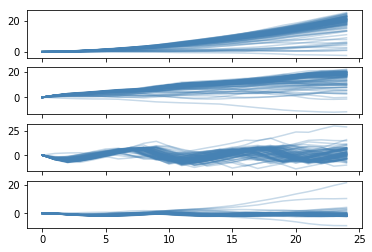

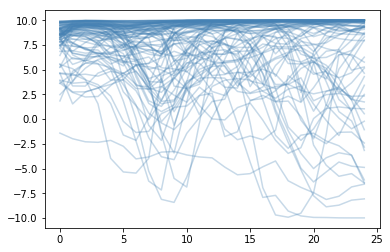

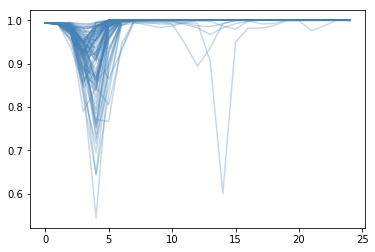

/home/juancamilog/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
  0%|          | 0/1000 [00:00<?, ?it/s]

Policy search iteration 1


Accumulated costs: 0.794127:  85%|████████▌ | 852/1000 [03:50<00:39,  3.70it/s]

In [ ]:
if use_cuda and torch.cuda.is_available():
    dyn = dyn.cuda()
    pol = pol.cuda()

# policy learning loop
for ps_it in range(100):
    # apply policy
    ret = apply_controller(
        env, pol, H,
        callback=None)
    exp.append_episode(*ret)

    # train dynamics
    X, Y = exp.get_dynmodel_dataset(deltas=True, return_costs=learn_reward)
    dyn.set_dataset(
        torch.tensor(X).to(dyn.X.device).float(),
        torch.tensor(Y).to(dyn.X.device).float())
    train_regressor(
        dyn, 2000, N_particles, True, opt1,
        log_likelihood=losses.gaussian_mixture_log_likelihood)

    # sample initial states for policy optimization
    x0 = torch.tensor(
        exp.sample_states(N_particles, timestep=0)).to(dyn.X.device).float()
    x0 += 1e-2*x0.std(0)*torch.randn_like(x0)
    utils.plot_rollout(x0, forward_fn, pol, H)

    # train policy
    print "Policy search iteration %d" % (ps_it+1)
    algorithms.mc_pilco(
        x0, forward_fn, dyn, pol, H, opt2, exp, 1000,
        maximize=False, pegasus=False, mm_states=True,
        mm_rewards=True, mpc=False, max_steps=25)
    utils.plot_rollout(x0, forward_fn, pol, H)
